# NLP Tweet Analysis  
### Will Byrd June 2024  
## Introduction  
In this NLP project, we will explore preprocesing of text data and sophisticated White Box modeling apporaches to determine the **sentiment** of tweets.  We can tell based on a quick review of the dataset that these are tweets made from attendees to South by Southwest or SXSW.  For context, SWSW is conference that celebrates technology and arts.  From a business perspective, we have been tasked with determining which brands are were rated most favorably so SXSW will know who to allocate resources to vendors next year.
  
  
In this notebook, we will use preprocessing tools such as:   
  
* regex - text data cleaning tool
* stemming - stripping affixes from words-leaving base forms
* lemmatization - ensuring the output word is a normalized version of the word
* label encoding - converting categorical variables into numerical format
* imputing - correcting NaNs
* tokenization - splitting text into smaller units such as words or bigrams/trigrams
* vectorization - converting text into numerical representations for modeling  
  
    
## Data  
Our analysis will be performed on a csv file from CrowdFlower via data.world.  This file contains over 9000 tweets that have been rated by humans to be positive, negative, or nuetral.  We also have insight into which brand or product is being targeted by each tweet ('emotion_in_tweet_is_directed_at') that can be analyzed during our EDA.  Ultimately, we will end with 3 features that we will use to predict sentiment:

* pos_tagged_text - strings of tokenized text with parts of speech labelled to each word
* bigrams - a column containing all bigrams (pairs of words) 
* trigrams - a column containing all trigrams (words occuring in groups of 3)  


## Goals
Our goal will be to build a model that can most accurately predict **Sentiment** of these tweets as it relates to specific brands.  Sentiment will be encoded to have a score between 1-3:

1 negative  
2 indifferent  
3 positive  

Since we already have a robust dataset with **Sentiment** (originally laballed as 'is_there_an_emotion_directed_at_a_brand_or_product'), we will build a supervised learning model using this df for training and testing. 
  
   
## Overview  
Let's take a look at the data to better understand what we need to do to the text data to analyze and model it.  Imputing the brand column that is labelled 'emotion_in_tweet_is_directed_at' will also be important to improve the sample size and power of our results.  We will build a variety of models:  

* Logistic Regression Model
* Decision Tree Classifier  
* K-Nearest Neighbors
* Gradient Boosting
  
After building these models and finetuning results, Stacking and Voting Ensemble methods are then used to further improve our models.  This is a costly process and takes our machine quite some time to run, but it ensures our results are optimal.

Importing all of the necessary libraries.

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from collections import Counter
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt', quiet=True)
np.random.seed(0)
from mlxtend.plotting import plot_decision_regions


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\byrdw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\byrdw\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#pip install -U imbalanced-learn


Reading in the csv tweets.csv to inspect specific rows and columns.

In [3]:
df = pd.read_csv('tweets.csv')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


Let's rename the column that contains all of the brands/products, since we will be working with that column throughout this notebook.

In [4]:
df.rename(columns={'emotion_in_tweet_is_directed_at': 'brand'}, inplace=True)

Let's take a quick look at the info of this df.  We can see lots of missing values in the **'brand'** column.  We can probably impute most of these from the **'tweet_text'** column.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   brand                                               3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


## Exploratory Data Analysis  
Now that the dataset is loaded, we can begin our EDA.  First thing to address is the imputation of values for our **'brand'** column.  Let's look at all unique values.

Looking at unique values in column 'emotion_in_tweet_is_directed_at' for imputation.

In [6]:
df['brand'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

Found some NaN values in our 'brand' column and want to impute some additional values where possible to reduce the amount of NaN values.  Looks like iPhone, iPad or iPad App, iPad, Google, Android, Apple, Android App, Other Google product or service, and Other Apple product or service are all of our values currently.  
  
Since we are more concerned with major brands and products, let's consolidate this list to:

* iPhone
* iPad
* Apple
* Google
* Android


In [7]:
# Define the list of words we want to check for in the 'tweet_text' column
words_to_check = ['iPhone', 'Apple', 'Google', 'iPad', 'Android']  # Change this to the words we want to check for

# Replace NaN values in 'tweet_text' column with an empty string
df['tweet_text'] = df['tweet_text'].fillna('')

# Filter the DataFrame to include only rows where 'brand' is NaN
filtered_df = df[df['brand'].isna()]

# Loop over each word to check for in the 'tweet_text' column
for word in words_to_check:
    # Use boolean indexing to find rows where 'tweet_text' contains the word
    rows_with_word = filtered_df[filtered_df['tweet_text'].str.contains(word, case=False)]
    
    # Update the value of 'brand' for the matching rows
    df.loc[rows_with_word.index, 'brand'] = word

# Print the updated DataFrame
print(df[['tweet_text', 'brand']])

                                             tweet_text               brand
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone
1     @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App
2     @swonderlin Can not wait for #iPad 2 also. The...                iPad
3     @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google
...                                                 ...                 ...
8716                      Ipad everywhere. #SXSW {link}                iPad
8717  Wave, buzz... RT @mention We interrupt your re...              Google
8718  Google's Zeiger, a physician never reported po...              Google
8719  Some Verizon iPhone customers complained their...              iPhone
8720  �ϡ�����_��ʋ�΋�ҋ�������⋁_��������_���RT @mentio...              Google

[8721 rows x 2 columns]


In [8]:
df.info() # checking the info again to see how many values we were able to impute

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8721 non-null   object
 1   brand                                               7984 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


Pretty solid improvement from 3169 values to 7984 values now.  Let's use mapping to consolidate these down to our targeted list we mentioned earlier:

* iPhone
* iPad
* Apple
* Google
* Android

In [9]:
# taking a quick look at unique value counts and we can see the value in consolidation
df['brand'].value_counts() 

iPad                               2389
Google                             2057
Apple                              1299
iPhone                              961
iPad or iPhone App                  451
Android                             433
Other Google product or service     282
Android App                          78
Other Apple product or service       34
Name: brand, dtype: int64

In [10]:
# Define the list of categories we keep
categories_to_keep = ['iPhone', 'iPad', 'Apple', 'Google', 'Android']

# Define a mapping of possible values to the categories we want to keep
mapping = {
    'iphone': 'iPhone',
    'ipad': 'iPad',
    'apple': 'Apple',
    'google': 'Google',
    'android': 'Android',
    'android app': 'Android',
    'ipad or iphone app': 'Apple',
    'other apple product or service': 'Apple',
    'other google product or service': 'Google'
}

# Convert all values to lowercase for case-insensitive matching
df['brand'] = df['brand'].str.lower()

# Map the values to the desired categories using the mapping defined
df['brand'] = df['brand'].apply(lambda x: mapping.get(x, x))

# Replace any remaining empty strings or NaNs with NaN
df['brand'].replace('', pd.NA, inplace=True)

# Print the updated DataFrame
print(df['brand'].value_counts())


iPad       2389
Google     2339
Apple      1784
iPhone      961
Android     511
Name: brand, dtype: int64


To perform analysis and build models, we will need to standardize all of our text data.  Standardizing the data includes:  

*  making everything lowercase  
*  removing nonword characters and symbols   
*  stripping whitespaces  
*  removing stop words  
*  Lemmatization  
*  Stemming  

Now, lets define a function that will use regex, lemmatization and stemming to clean our data.  For context, lemmatization and stemming is a process that essentially reduces words down to their bases.  Running and runs become run.  Partying and parties become party, etc.

In [11]:
# Text cleaning using regex
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE) # removing http, www, hhtps, and spacces from tweet
    tweet = re.sub(r'\@\w+|\#', '', tweet) ## removing @, #
    tweet = tweet.lower()  # make all text lower case
    tweet = re.sub(r'\W', ' ', tweet) # replace non word characters with a space
    tweet = re.sub(r'\s+', ' ', tweet)  # replace multiple spaces with a single space
    tweet = tweet.strip() # removes leading whitespaces
    stop_words = set(stopwords.words('english')) # removing stop words
    lemmatizer = WordNetLemmatizer() # lemmatizing words, turning running to run
    words = tweet.split() # creating a list of words
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # list comprehension to lemmatize and removie stop words
    return ' '.join(cleaned_words) # joining clean and lemmatized words into a single string

Now we will need to turn our columns into strings for analysis/modeling.  

In [12]:
df['tweet_text'] = df['tweet_text'].astype(str)

In [13]:
df['cleaned_tweet'] = df['tweet_text'].apply(clean_tweet)

Let's take a look at our work in the new column we have created called **'cleaned_tweet'**.  This is a good chance to take a look at what the stemming and lemmatization has done to our text data.

In [14]:
df.head()

,tweet_text,brand,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive emotion,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative emotion,hope year festival crashy year iphone app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...


Tweets are cleaned and we can move on to the next step-encoding.  
Label Encoding values in the 'is_there_an_emotion_directed_at_a_brand_or_product' column to make a new column, 'sentiment' is appropriaate since the values are ordinal.   
0=Undefined  
1=Negative  
2=Indifferent  
3=Positve  


In [15]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])

Looks like we have some more rows we can drop.  If we can't decipher sentiment (denoted as a value of 0), we can't use these in our modeling.  Goodbye!

In [16]:
df['sentiment']
df[df['sentiment']==0]

,tweet_text,brand,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment
88,Thanks to @mention for publishing the news of ...,NaN,I can't tell,thanks publishing news new medical apps sxswi ...,0
100,���@mention &quot;Apple has opened a pop-up st...,iPad,I can't tell,quot apple opened pop store austin nerd town s...,0
228,Just what America needs. RT @mention Google to...,Google,I can't tell,america need rt google launch major new social...,0
330,The queue at the Apple Store in Austin is FOUR...,Apple,I can't tell,queue apple store austin four block long crazy...,0
357,Hope it's better than wave RT @mention Buzz is...,Google,I can't tell,hope better wave rt buzz google previewing soc...,0
...,...,...,...,...,...
8650,It's funny watching a room full of people hold...,iPad,I can't tell,funny watching room full people hold ipad air ...,0
8662,"@mention yeah, we have @mention , Google has n...",Google,I can't tell,yeah google nothing u sxsw,0
8667,"@mention Yes, the Google presentation was not ...",Google,I can't tell,yes google presentation exactly expecting sxsw,0
8687,&quot;Do you know what Apple is really good at...,iPad,I can't tell,quot know apple really good making feel bad xm...,0


In [17]:
# Drop rows where 'sentiment' is equal to 0 in the original DataFrame
df.drop(df[df['sentiment'] == 0].index, inplace=True)


Let's take another look to make sure all NaN values have been addressed.

In [18]:
# quick way to view all NaN values in a specific column
df['brand'].isna().sum()

732

But I'm still seeing some NaN values.  Let's finish cleaning this up.

In [19]:
df.dropna(subset=['brand'], inplace=True)

In [20]:
df.isnull().sum()

tweet_text                                            0
brand                                                 0
is_there_an_emotion_directed_at_a_brand_or_product    0
cleaned_tweet                                         0
sentiment                                             0
dtype: int64

In [21]:
# we need to reset our index for matching in our modelling.
df.reset_index(drop=True, inplace=True)

For our **'brand'** column we will need to use **OneHotEncoder** to address the categorical variable in that column.  Notice since there is no ordinal relationship between the values in this column, we have to use OneHotEncoding vs label encoding.

In [22]:
# Use OneHotEncoder from scikit-learn
encoder = OneHotEncoder(categories=[['iPhone', 'iPad', 'Apple', 'Google', 'Android']], drop=None, sparse=False)
encoded_data = encoder.fit_transform(df[['brand']])

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['brand']))

# Concatenate the encoded DataFrame with the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop the original 'brand' column if no longer needed
#df.drop(columns=['brand'], inplace=True)

# Print the updated DataFrame
df.head()


C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,tweet_text,brand,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment,brand_iPhone,brand_iPad,brand_Apple,brand_Google,brand_Android
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1,1.0,0.0,0.0,0.0,0.0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive emotion,know awesome ipad iphone app likely appreciate...,3,0.0,0.0,1.0,0.0,0.0
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3,0.0,1.0,0.0,0.0,0.0
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative emotion,hope year festival crashy year iphone app sxsw,1,0.0,0.0,1.0,0.0,0.0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3,0.0,0.0,0.0,1.0,0.0


One last review for NaN values

In [23]:
nan_values = df.isna().any()

# Print the columns with NaN values, if any
print(nan_values)

tweet_text                                            False
brand                                                 False
is_there_an_emotion_directed_at_a_brand_or_product    False
cleaned_tweet                                         False
sentiment                                             False
brand_iPhone                                          False
brand_iPad                                            False
brand_Apple                                           False
brand_Google                                          False
brand_Android                                         False
dtype: bool


Double check!

In [24]:
df.isnull().sum()

tweet_text                                            0
brand                                                 0
is_there_an_emotion_directed_at_a_brand_or_product    0
cleaned_tweet                                         0
sentiment                                             0
brand_iPhone                                          0
brand_iPad                                            0
brand_Apple                                           0
brand_Google                                          0
brand_Android                                         0
dtype: int64

Great work! All NaN values are gone and we have imputed 4000 values!

Now it's time to Tokenize our text.  Tokenizing is an important preprocessing step as it allows us to further analyze the text.  We can create bigrams, trigrams, and determine feature importance.

tokenizing 'cleaned_tweet' to 'tokenized_tweets'

In [25]:
df['tokenized_tweets'] = df['cleaned_tweet'].apply(word_tokenize)
df.head()

,tweet_text,brand,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment,brand_iPhone,brand_iPad,brand_Apple,brand_Google,brand_Android,tokenized_tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1,1.0,0.0,0.0,0.0,0.0,"[3g, iphone, 3, hr, tweeting, rise_austin, dea..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive emotion,know awesome ipad iphone app likely appreciate...,3,0.0,0.0,1.0,0.0,0.0,"[know, awesome, ipad, iphone, app, likely, app..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3,0.0,1.0,0.0,0.0,0.0,"[wait, ipad, 2, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative emotion,hope year festival crashy year iphone app sxsw,1,0.0,0.0,1.0,0.0,0.0,"[hope, year, festival, crashy, year, iphone, a..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3,0.0,0.0,0.0,1.0,0.0,"[great, stuff, fri, sxsw, marissa, mayer, goog..."


Pretty simple to tokenize the text.  Now that the individual words are tokenized, let's create a bag of words.  This will allow us to check frequency of words.

In [26]:
def count_vectorize(tokenized_list):  # Define the function with a list of tokenized tweets as input
    corpus = {}  # Initialize an empty dictionary to store word counts
    
    for tokenized in tokenized_list:  # Iterate over each tokenized tweet
        for word in tokenized:  # Iterate over each word in the tokenized tweet
            if word in corpus:  # If the word is already in the dictionary
                corpus[word] += 1  # Increment its count by 1
            else:  # If the word is not in the dictionary
                corpus[word] = 1  # Add it to the dictionary with a count of 1

    return corpus  # Return the dictionary containing word counts

# Vectorize the tokenized tweets
text_vectorized = count_vectorize(df['tokenized_tweets'])  # Call the function and store the result
text_vectorized  # Output the resulting dictionary

{'3g': 29,
 'iphone': 1492,
 '3': 143,
 'hr': 5,
 'tweeting': 28,
 'rise_austin': 2,
 'dead': 7,
 'need': 218,
 'upgrade': 13,
 'plugin': 4,
 'station': 9,
 'sxsw': 8324,
 'know': 181,
 'awesome': 115,
 'ipad': 2397,
 'app': 751,
 'likely': 11,
 'appreciate': 4,
 'design': 130,
 'also': 73,
 'giving': 65,
 'free': 242,
 't': 2,
 'wait': 72,
 '2': 1160,
 'sale': 43,
 'hope': 47,
 'year': 148,
 'festival': 22,
 'crashy': 2,
 'great': 174,
 'stuff': 30,
 'fri': 7,
 'marissa': 176,
 'mayer': 203,
 'google': 2501,
 'tim': 17,
 'reilly': 8,
 'tech': 113,
 'book': 36,
 'conference': 69,
 'amp': 715,
 'matt': 11,
 'mullenweg': 2,
 'wordpress': 7,
 'new': 1020,
 'apps': 199,
 'speechtherapy': 3,
 'communication': 22,
 'showcased': 18,
 'iear': 3,
 'edchat': 4,
 'asd': 3,
 'starting': 26,
 'ctia': 3,
 'around': 124,
 'corner': 13,
 'googleio': 2,
 'hop': 3,
 'skip': 3,
 'jump': 6,
 'good': 147,
 'time': 272,
 'android': 561,
 'fan': 33,
 'beautifully': 2,
 'smart': 61,
 'simple': 10,
 'idea': 41

checking frequency of words

In [27]:
freq_df = pd.DataFrame(list(text_vectorized.items()), columns=['Word', 'Frequency'])
freq_df

,Word,Frequency
0,3g,29
1,iphone,1492
2,3,143
3,hr,5
4,tweeting,28
...,...,...
8027,complained,1
8028,yorkers,1
8029,ϡ,1
8030,ʋ,1


Let's visualize the tope 20 most frequent words

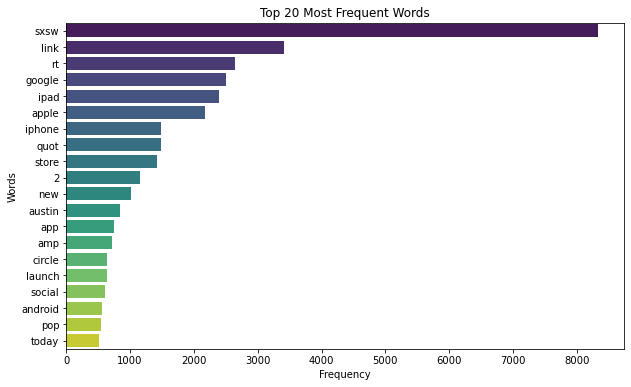

In [28]:
# Convert the word frequency dictionary to a DataFrame
freq_df = pd.DataFrame(list(text_vectorized.items()), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=freq_df.head(20), palette='viridis')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Now we can take a look at this a different way- let's look at the normalized frequency of each word

In [29]:
# Calculate the total number of tokens
total_word_count = freq_df['Frequency'].sum()

# Print the total number of tokens
print("Total word count:", total_word_count)

# Extract the top 50 most common words
df_top_50 = freq_df.head(50)

# Print the top 50 words and their normalized frequencies
print(f'{"Word":10} Normalized Frequency')
for word in df_top_50.iterrows():
    normalized_frequency = word[1]['Frequency'] / total_word_count
    print(f'{word[1]["Word"]:10} {normalized_frequency:.6f}')


Total word count: 92923
Word       Normalized Frequency
sxsw       0.089580
link       0.036676
rt         0.028389
google     0.026915
ipad       0.025796
apple      0.023460
iphone     0.016056
quot       0.015906
store      0.015238
2          0.012483
new        0.010977
austin     0.009147
app        0.008082
amp        0.007695
circle     0.006898
launch     0.006887
social     0.006457
android    0.006037
pop        0.005854
today      0.005585
network    0.004778
ipad2      0.004617
line       0.004595
get        0.004445
via        0.003928
called     0.003691
mobile     0.003605
party      0.003594
major      0.003175
one        0.003132
like       0.002959
time       0.002927
sxswi      0.002906
temporary  0.002723
day        0.002712
free       0.002604
opening    0.002594
map        0.002572
win        0.002550
possibly   0.002529
w          0.002529
open       0.002421
check      0.002368
need       0.002346
people     0.002346
downtown   0.002303
go         0.002228
u   

This tells us that SXSW is the most commonly occuring word.  Another interesting thing to notice is the order in which our main brands/product appear.  This is the percentage of words that in the corpus that are the specific word.  So out of nearly 100,000 words-8.9% of them are sxsw.

* google     2.6915%  
* ipad       2.5796%  
* apple      2.3460%  
* iphone     1.6056%
* android    0.6037%

Let's get a total count for how many tweets talk about each specific brand.  Remmeber there are 7984 tweets with a specific brand focus.

In [30]:
# Calculating the total count of tweets directed at Google
google_count = df[df['brand'] == 'Google']['brand'].count()
google_count

2289

In [31]:
# Calculating percentage of tweets that are about Google
google_count = df['brand'].value_counts().get('Google', 0)
total_count = df['brand'].count()
google_percent = google_count / total_count
google_percent


0.2920387854044399

In [32]:
# Calculating the total count of tweets directed at Apple
apple_count = df[df['brand'] == 'Apple']['brand'].count()
apple_count

1764

In [33]:
# Calculating percentage of tweets that are about Apple
apple_count = df['brand'].value_counts().get('Apple', 0)
total_count = df['brand'].count()
apple_percent = apple_count / total_count
apple_percent


0.22505741260525644

In [34]:
# Calculating the total count of tweets directed at iPad
iPad_count = df[df['brand'] == 'iPad']['brand'].count()
iPad_count

2346

In [35]:
# Calculating percentage of tweets that are about iPad
iPad_count = df['brand'].value_counts().get('iPad', 0)
total_count = df['brand'].count()
iPad_percent = iPad_count / total_count
iPad_percent


0.29931104873692266

In [36]:
# Calculating the total count of tweets directed at iPhone
iPhone_count = df[df['brand'] == 'iPhone']['brand'].count()
iPhone_count

934

In [37]:
# Calculating percentage of tweets that are about iPhone
iPhone_count = df['brand'].value_counts().get('iPhone', 0)
total_count = df['brand'].count()
iPhone_percent = iPhone_count / total_count
iPhone_percent


0.1191630517989283

In [38]:
# Calculating the total count of tweets directed at Android
Android_count = df[df['brand'] == 'Android']['brand'].count()
Android_count

505

In [39]:
# Calculating percentage of tweets that are about Android
Android_count = df['brand'].value_counts().get('Android', 0)
total_count = df['brand'].count()
Android_percent = Android_count / total_count
Android_percent


0.06442970145445266

Now let's take a look at the histogram of TF-IDF Values for the 50 most common words


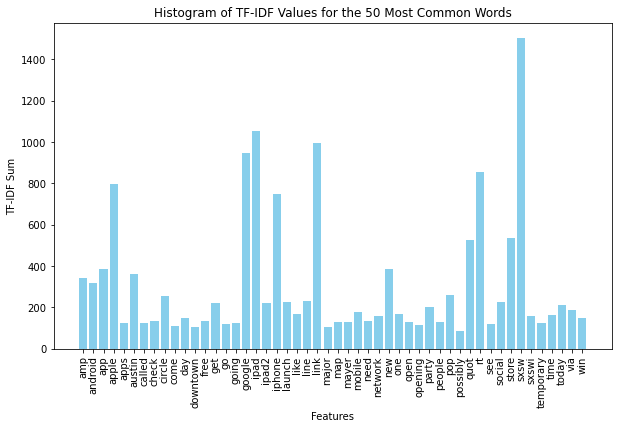

In [40]:
# Ensure 'cleaned_tweet' column is of string type
df['cleaned_tweet'] = df['cleaned_tweet'].astype(str)

# Apply the clean_tweet function to each entry in the 'cleaned_tweet' column
df['cleaned_text'] = df['cleaned_tweet'].apply(clean_tweet)

# Convert the cleaned text column to a list
text_data = df['cleaned_text'].tolist()

# Initialize a CountVectorizer with a maximum of 50 features
count_vectorizer = CountVectorizer(max_features=50)

# Fit and transform the text data to a document-term matrix
X_counts = count_vectorizer.fit_transform(text_data)

# Get the most common words (features) from the count vectorizer
common_words = count_vectorizer.get_feature_names_out()

# Initialize a TfidfVectorizer with the common words as vocabulary
vectorizer_tfid = TfidfVectorizer(vocabulary=common_words)

# Fit and transform the text data to a TF-IDF matrix
X_tfid = vectorizer_tfid.fit_transform(text_data)

# Convert the TF-IDF matrix to an array
tfidf_matrix = X_tfid.toarray()

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = vectorizer_tfid.get_feature_names_out()

# Sum the TF-IDF values for each feature across all documents
tfidf_sums = np.sum(tfidf_matrix, axis=0)

# Plot a histogram of the TF-IDF values for the 50 most common words
plt.figure(figsize=(10, 6))
plt.bar(feature_names, tfidf_sums, color='skyblue')
plt.xlabel('Features')
plt.ylabel('TF-IDF Sum')
plt.title('Histogram of TF-IDF Values for the 50 Most Common Words')
plt.xticks(rotation=90) 
plt.show()  


Let's add Part of Speech Tagging here as well.  This is another level preprocessing and can improve our model.

In [41]:
def pos_tagging(text):
    # Tokenize the input text into individual words
    words = nltk.word_tokenize(text)
    
    # Assign part-of-speech tags to each word
    pos_tags = nltk.pos_tag(words)
    
    # Format each word and its POS tag as 'word_tag' and join them into a single string
    return ' '.join([f"{word}_{tag}" for word, tag in pos_tags])

# Apply the pos_tagging function to each entry in the 'cleaned_text' column
# and store the result in a new column 'pos_tagged_text'
df['pos_tagged_text'] = df['cleaned_text'].apply(pos_tagging)


In [42]:
# Inspecting our df after adding some columns
df.head()

,tweet_text,brand,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_tweet,sentiment,brand_iPhone,brand_iPad,brand_Apple,brand_Google,brand_Android,tokenized_tweets,cleaned_text,pos_tagged_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,3g iphone 3 hr tweeting rise_austin dead need ...,1,1.0,0.0,0.0,0.0,0.0,"[3g, iphone, 3, hr, tweeting, rise_austin, dea...",3g iphone 3 hr tweeting rise_austin dead need ...,3g_CD iphone_NN 3_CD hr_NN tweeting_VBG rise_a...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive emotion,know awesome ipad iphone app likely appreciate...,3,0.0,0.0,1.0,0.0,0.0,"[know, awesome, ipad, iphone, app, likely, app...",know awesome ipad iphone app likely appreciate...,know_VB awesome_JJ ipad_NN iphone_NN app_NN li...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad 2 also sale sxsw,3,0.0,1.0,0.0,0.0,0.0,"[wait, ipad, 2, also, sale, sxsw]",wait ipad 2 also sale sxsw,wait_NN ipad_NN 2_CD also_RB sale_NN sxsw_NN
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative emotion,hope year festival crashy year iphone app sxsw,1,0.0,0.0,1.0,0.0,0.0,"[hope, year, festival, crashy, year, iphone, a...",hope year festival crashy year iphone app sxsw,hope_NN year_NN festival_NN crashy_JJ year_NN ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,3,0.0,0.0,0.0,1.0,0.0,"[great, stuff, fri, sxsw, marissa, mayer, goog...",great stuff fri sxsw marissa mayer google tim ...,great_JJ stuff_NN fri_NN sxsw_NN marissa_FW ma...


Now that we have created our bag of words, let's create bigrams and trigrams.  These can be important in fully understanding meaning in text.  For example-which iPad is everyone talking about?

In [43]:
def generate_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return [' '.join(gram) for gram in n_grams]

# Apply the function to generate bigrams and trigrams
df['bigrams'] = df['cleaned_text'].apply(lambda x: generate_ngrams(x, 2))
df['trigrams'] = df['cleaned_text'].apply(lambda x: generate_ngrams(x, 3))

# Display the DataFrame with bigrams and trigrams
df['bigrams']

0       [3g iphone, iphone 3, 3 hr, hr tweeting, tweet...
1       [know awesome, awesome ipad, ipad iphone, ipho...
2       [wait ipad, ipad 2, 2 also, also sale, sale sxsw]
3       [hope year, year festival, festival crashy, cr...
4       [great stuff, stuff fri, fri sxsw, sxsw mariss...
                              ...                        
7833        [ipad everywhere, everywhere sxsw, sxsw link]
7834    [wave buzz, buzz rt, rt interrupt, interrupt r...
7835    [google zeiger, zeiger physician, physician ne...
7836    [verizon iphone, iphone customer, customer com...
7837    [ϡ _, _ ʋ, ʋ ҋ, ҋ _, _ _, _ rt, rt google, goo...
Name: bigrams, Length: 7838, dtype: object

Let's create a graph to view the top 50 most occuring bigrms.  This can give insight into which products people are talking about.

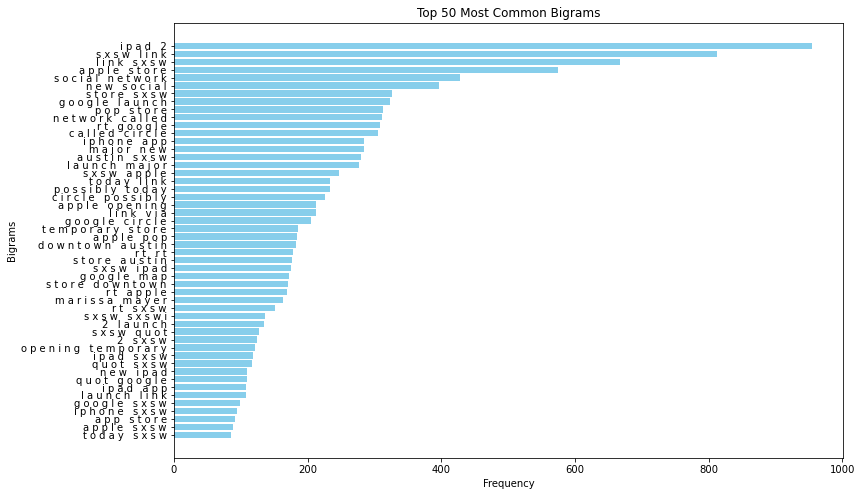

In [44]:
# Flatten the list of bigrams
all_bigrams = [bigram for sublist in df['bigrams'] for bigram in sublist]

# Count the frequency of each bigram
bigram_freq = Counter(all_bigrams)

# Get the top 50 most common bigrams
top_50_bigrams = bigram_freq.most_common(50)

# Prepare data for the histogram
bigrams, counts = zip(*top_50_bigrams)
bigram_labels = [' '.join(bigram) for bigram in bigrams]

# Plot the histogram
plt.figure(figsize=(12, 8))
plt.barh(bigram_labels, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 50 Most Common Bigrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

Now let's do the same thing for trigrams.

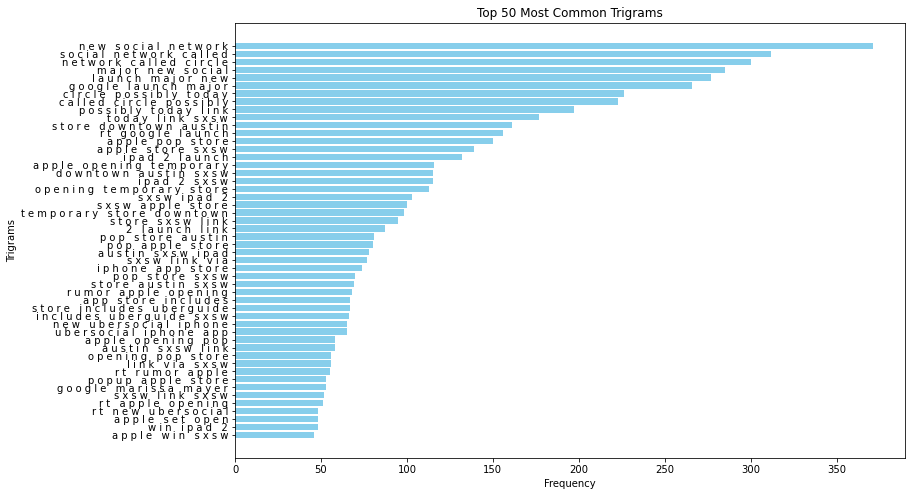

In [45]:
# Flatten the list of trigrams
all_trigrams = [trigram for sublist in df['trigrams'] for trigram in sublist]

# Count the frequency of each bigram
trigram_freq = Counter(all_trigrams)

# Get the top 50 most common bigrams
top_50_trigrams = trigram_freq.most_common(50)

# Prepare data for the histogram
trigrams, counts = zip(*top_50_trigrams)
trigram_labels = [' '.join(trigram) for trigram in trigrams]

# Plot the histogram
plt.figure(figsize=(12, 8))
plt.barh(trigram_labels, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.title('Top 50 Most Common Trigrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

Now I want to see a histogram showing the sentiment associated with each brand.

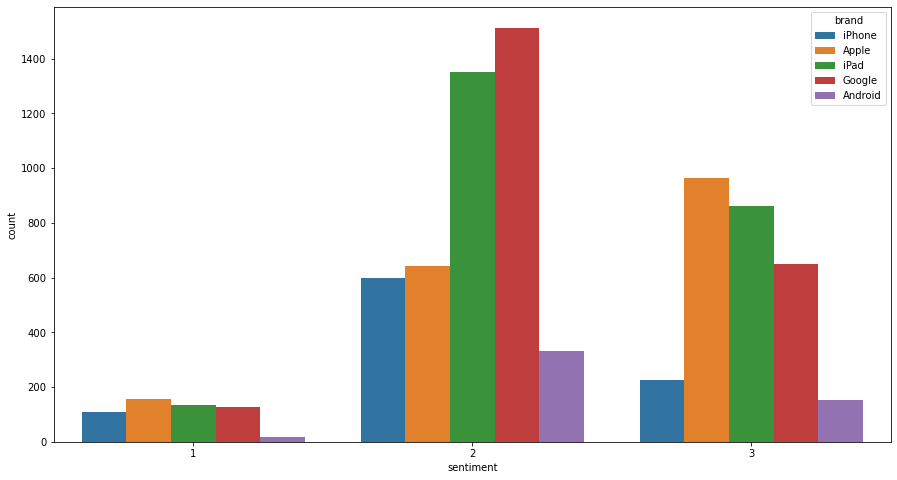

In [46]:
plt.figure(figsize=(15, 8))
sns.countplot(x='sentiment', hue='brand', data=df)
plt.show()

We can see most of the tweets are indifferent or positive to the brands and only a relative few are negative.  Let's reproduce this graph, but focus on the brand instead of the sentiment.

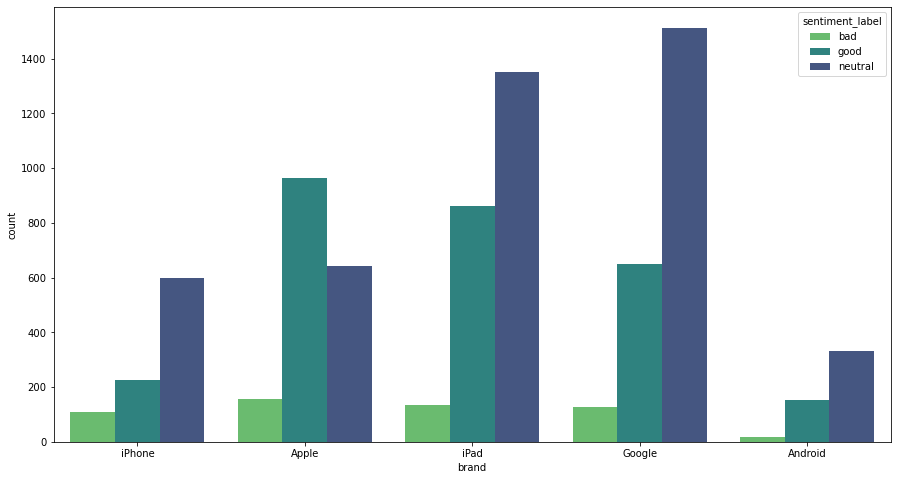

In [47]:
sentiment_labels = {1: 'bad', 2: 'neutral', 3: 'good'}
df['sentiment_label'] = df['sentiment'].map(sentiment_labels)
gradient_palette = sns.color_palette("viridis_r", 3)
plt.figure(figsize=(15, 8))
sns.countplot(x='brand', hue='sentiment_label', data=df, palette=gradient_palette)
plt.show()

Ok, now we can see a little bit more clearly what people are saying about each brand.  Most of the tweets about Apple are good and most of the tweets about iPhone, iPad, Google, and ANdroid are nuetral. This makes sense, because we could see in the previous chart that most of the tweets are nuetral.

We've got some pretty good descriptive and visualizations here.  Time to build our models.

First thing we need to do is turn our variables into strings.  This will allow our ColumnTransformer class to prepare the text for Term Frequency-Inverse Document Frequency (TF-IDF).  This is a stat that determines the specific words importance relative to the all words in the corpus.

In [48]:
df['pos_tagged_text'] = df['pos_tagged_text'].astype(str)
df['bigrams'] = df['bigrams'].astype(str)
df['trigrams'] = df['trigrams'].astype(str)
df['tokenized_tweets'] = df['tokenized_tweets'].astype(str)

Step 1 for all modeling-defining X and Y variables.  
For us, the **'sentiment'** value is going to be the dependant variable and our independant variables are:  
* **'pos_tagged_text'**  
* **'bigrams'**  
* **'trigrams'**  
* **'brand_iPhone'**  
* **'brand_iPad'**  
* **'brand_Apple'**  
* **'brand_Google'**  
* **'brand_Android'**

In [49]:
X = df[['pos_tagged_text', 'bigrams', 'trigrams', 'brand_iPhone', 'brand_iPad', 'brand_Apple', 'brand_Google', 'brand_Android']]
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

OK! We're ready to start building some models.  Here are the models we are going to build:   
Let's start with a baseline **Logistic Regression model.**  Logistic Regressions are great for modeling probability of outcomes.

We will define preprocessor as the ColumnTransformer function that will use TFIDF vectorization on our text features.  This preprocessor will be recycled for every model we build.

In [50]:
# Step 1: Preprocess the text data
preprocessor = ColumnTransformer(
    transformers=[
        ('pos_tagged_text', TfidfVectorizer(max_features=5000), 'pos_tagged_text'),
        ('bigrams', TfidfVectorizer(max_features=5000), 'bigrams'),
        ('trigrams', TfidfVectorizer(max_features=5000), 'trigrams')
    ]
)

# Step 2: Define and train our logistic regression model
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

logistic_pipeline.fit(X_train, y_train)

# Step 3: Evaluate the model
y_pred = logistic_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.18      0.28       117
           2       0.69      0.81      0.75       883
           3       0.62      0.56      0.59       568

    accuracy                           0.67      1568
   macro avg       0.64      0.51      0.54      1568
weighted avg       0.66      0.67      0.65      1568



<Figure size 720x504 with 0 Axes>

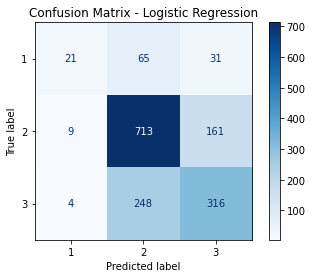

In [64]:
# Visualization: Confusion Matrix
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay.from_estimator(logistic_pipeline, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Not a bad start.  Let's see if we can improve our scores by using **GridSearchCV on the Logistic Regression Model** to find the best parameters.  GridSearchCV will run the model with every combinaiton of parameters we give it and then pick the best model.    Notice how this code block will also output the best results as well as running the best results and producing the stats.  These can take a while to run sometimes.  

In [51]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['liblinear', 'saga']  # Solvers
}

# Set up GridSearchCV with the logistic regression pipeline
grid_search = GridSearchCV(estimator=logistic_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the pipeline with grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters found: {best_params}')
print(f'Best cross-validation accuracy: {best_score:.2f}')

# Make predictions with the best estimator
best_logistic_model = grid_search.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test)

# Evaluate the best model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f'Logistic Regression Accuracy: {accuracy_logistic:.2f}')
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

Best parameters found: {'classifier__C': 1, 'classifier__solver': 'saga'}
Best cross-validation accuracy: 0.66
Logistic Regression Accuracy: 0.67
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.18      0.28       117
           2       0.69      0.81      0.75       883
           3       0.62      0.56      0.59       568

    accuracy                           0.67      1568
   macro avg       0.64      0.51      0.54      1568
weighted avg       0.66      0.67      0.65      1568



Now Let's build a **Decision Tree Classifier** using our preprocessor from above.  A Decision Tree is another model great for classifications.   
Essentially, we create a model that predicts the value of a y-variable by learning simple decision rules inferred from the x-variables.

In [52]:
from sklearn.tree import DecisionTreeClassifier

# Define pipeline for Decision Tree Classifier
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Fit the pipeline on the training data
decision_tree_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred_decision_tree = decision_tree_pipeline.predict(X_test)

# Evaluate the model
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print(f'Decision Tree Classifier Accuracy: {accuracy_decision_tree:.2f}')
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, y_pred_decision_tree))


Decision Tree Classifier Accuracy: 0.59
Decision Tree Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.29      0.16      0.21       117
           2       0.65      0.69      0.67       883
           3       0.52      0.52      0.52       568

    accuracy                           0.59      1568
   macro avg       0.49      0.46      0.47      1568
weighted avg       0.58      0.59      0.58      1568



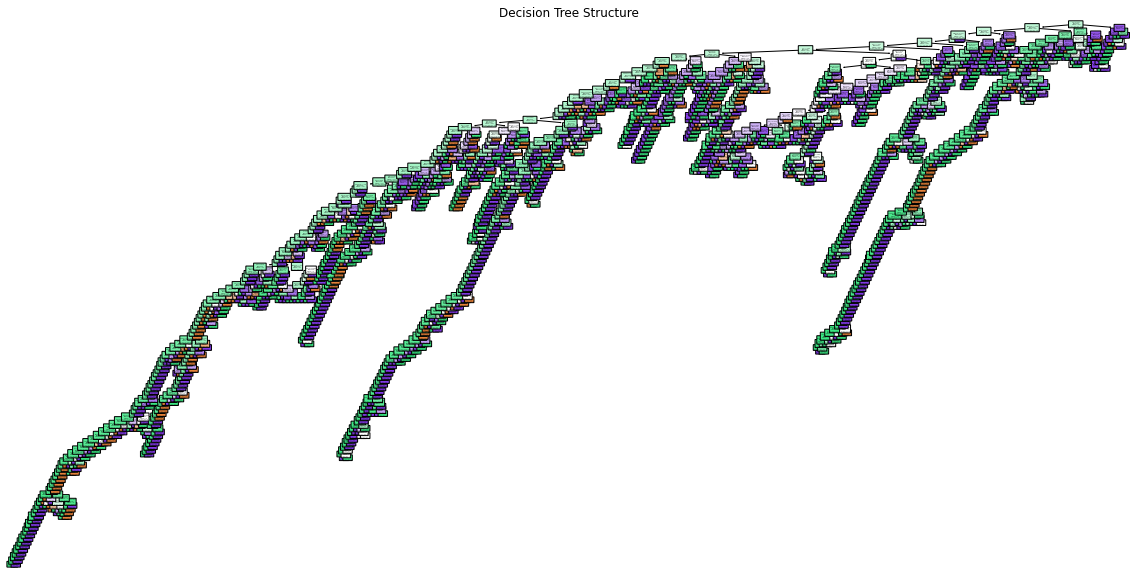

In [66]:
from sklearn.tree import plot_tree

# Visualization: Decision Tree Structure
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_pipeline.named_steps['classifier'],
          feature_names=get_feature_names(decision_tree_pipeline.named_steps['preprocessor']),
          class_names=[str(cls) for cls in np.unique(y_train)],
          filled=True,
          rounded=True)
plt.title('Decision Tree Structure')
plt.show()


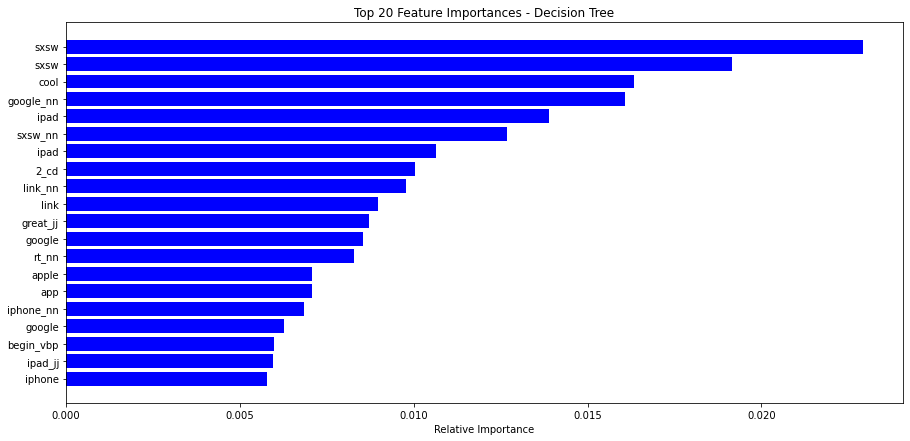

In [65]:
# Function to extract feature names correctly
def get_feature_names(preprocessor):
    output_features = []
    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names = transformer.get_feature_names_out()
            output_features.extend(feature_names)
        elif hasattr(transformer, 'transformers_'):  # Handling nested ColumnTransformer
            nested_features = get_feature_names(transformer)
            output_features.extend(nested_features)
        else:
            output_features.extend(columns)
    return output_features

# Visualization: Feature Importance using Decision Tree
def plot_feature_importances(model, feature_names, top_features=20):
    importances = model.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[-top_features:]

    plt.figure(figsize=(15, 7))
    plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title('Top 20 Feature Importances - Decision Tree')
    plt.show()

# Extract feature names from the preprocessor
feature_names = get_feature_names(decision_tree_pipeline.named_steps['preprocessor'])
feature_names = np.array(feature_names)

# Plot feature importances
plot_feature_importances(decision_tree_pipeline, feature_names)


Now let's run **GridSearchCV** to optimize our **Decision Tree Classifier**.  Notice how this code block will also output the best results as well as running the best results and producing the stats.

In [53]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_depth': [1, 2, 5],
    'classifier__min_samples_split': [1, 2, 5,],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV with the decision tree pipeline
grid_search = GridSearchCV(estimator=decision_tree_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the pipeline with grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters found: {best_params}')
print(f'Best cross-validation accuracy: {best_score:.2f}')

# Make predictions with the best estimator
best_tree_model = grid_search.best_estimator_
y_pred_tree = best_tree_model.predict(X_test)

# Evaluate the best model
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f'Decision Tree Accuracy: {accuracy_tree:.2f}')
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))

C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_es

Best parameters found: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation accuracy: 0.60
Decision Tree Accuracy: 0.60
Decision Tree Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       117
           2       0.59      0.98      0.74       883
           3       0.81      0.14      0.24       568

    accuracy                           0.60      1568
   macro avg       0.47      0.37      0.33      1568
weighted avg       0.63      0.60      0.50      1568



C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\byrdw\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now we're going to run a **K-Nearest Neighbors Classifier**. KNN is built on the idea that similar data points often have simlar features.  So during the training phase, KNN calculates the Euclidean Distance between points and groups them by the 'k' number of nearest neighbors.  The default is 5 and what we use in our basline model.

In [54]:
from sklearn.neighbors import KNeighborsClassifier

# Define pipeline for KNN Classifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Fit the pipeline on the training data
knn_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred_knn = knn_pipeline.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Classifier Accuracy: {accuracy_knn:.2f}')
print("KNN Classifier Classification Report:")
print(classification_report(y_test, y_pred_knn))


KNN Classifier Accuracy: 0.63
KNN Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.35      0.18      0.24       117
           2       0.65      0.83      0.73       883
           3       0.61      0.41      0.49       568

    accuracy                           0.63      1568
   macro avg       0.54      0.47      0.48      1568
weighted avg       0.61      0.63      0.60      1568



Now let's run GridSearchCV to optimize our **KNN Classifier**. Notice how this code block will also output the best results as well as running the best results and producing the stats.  


In [55]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__p': [1, 2]
}

# Set up GridSearchCV with the KNN pipeline
grid_search_knn = GridSearchCV(estimator=knn_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the pipeline with grid search
grid_search_knn.fit(X_train, y_train)

# Get the best parameters and best score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print(f'Best parameters found for KNN: {best_params_knn}')
print(f'Best cross-validation accuracy for KNN: {best_score_knn:.2f}')

# Make predictions with the best estimator
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)

# Evaluate the best model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn:.2f}')
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

Best parameters found for KNN: {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 11, 'classifier__p': 2, 'classifier__weights': 'distance'}
Best cross-validation accuracy for KNN: 0.64
KNN Accuracy: 0.64
KNN Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.15      0.23       117
           2       0.65      0.84      0.73       883
           3       0.62      0.44      0.51       568

    accuracy                           0.64      1568
   macro avg       0.59      0.47      0.49      1568
weighted avg       0.63      0.64      0.62      1568



Building Gradient Boosting classifier

In [56]:
# Create a pipeline that includes preprocessing and the Gradient Boosting classifier
gradient_boosting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Train the pipeline
gradient_boosting_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_gradient_boosting = gradient_boosting_pipeline.predict(X_test)

# Evaluate the pipeline
accuracy_gradient_boosting = accuracy_score(y_test, y_pred_gradient_boosting)
print(f'Gradient Boosting Accuracy: {accuracy_gradient_boosting:.2f}')
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gradient_boosting))

Gradient Boosting Accuracy: 0.66
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.09      0.15       117
           2       0.65      0.93      0.77       883
           3       0.73      0.36      0.48       568

    accuracy                           0.66      1568
   macro avg       0.64      0.46      0.47      1568
weighted avg       0.67      0.66      0.62      1568



Finetuning Gradient Bossting model via GridSearchCV

In [58]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [10, 20],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 4],
    'classifier__subsample': [0.8, 1.0]
}

# Set up GridSearchCV with the Gradient Boosting pipeline
grid_search_gb = GridSearchCV(estimator=gradient_boosting_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Train the pipeline with grid search
grid_search_gb.fit(X_train, y_train)

# Get the best parameters and best score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print(f'Best parameters found for Gradient Boosting: {best_params_gb}')
print(f'Best cross-validation accuracy for Gradient Boosting: {best_score_gb:.2f}')

# Make predictions with the best estimator
best_gb_model = grid_search_gb.best_estimator_
y_pred_gradient_boosting = best_gb_model.predict(X_test)

# Evaluate the best model
accuracy_gradient_boosting = accuracy_score(y_test, y_pred_gradient_boosting)
print(f'Gradient Boosting Accuracy: {accuracy_gradient_boosting:.2f}')
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gradient_boosting))

Best parameters found for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__n_estimators': 20, 'classifier__subsample': 0.8}
Best cross-validation accuracy for Gradient Boosting: 0.62
Gradient Boosting Accuracy: 0.64
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.09      0.15       117
           2       0.61      0.97      0.75       883
           3       0.82      0.23      0.35       568

    accuracy                           0.64      1568
   macro avg       0.70      0.43      0.42      1568
weighted avg       0.69      0.64      0.56      1568



Now let's take all of those models and use ensemble methods to analyze them even further!  First we will look at the Stacking method.

In [59]:
# Define base models
estimators = [
    ('decision_tree', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('logistic', LogisticRegression(max_iter=1000)),
    ('gradient_boosting', GradientBoostingClassifier())
]

# Create a pipeline that includes preprocessing and the stacking classifier
stacking_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000)
    ))
])

# Train the pipeline
stacking_clf.fit(X_train, y_train)

#make predictions
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluate the pipeline
stack_accuracy = stacking_clf.score(X_test, y_test)
print(f'Stacking Classifier Accuracy: {stack_accuracy:.2f}')
print("Stacking Classifier Classification Report:")
print(classification_report(y_test, y_pred_stacking))


Stacking Classifier Accuracy: 0.69
Stacking Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.19      0.29       117
           2       0.69      0.85      0.76       883
           3       0.68      0.53      0.59       568

    accuracy                           0.69      1568
   macro avg       0.66      0.52      0.55      1568
weighted avg       0.68      0.69      0.67      1568



Now let's look a the Voting method.

In [60]:
# Similarly, for voting classifier
voting_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(
        estimators=[
            ('decision_tree', DecisionTreeClassifier()),
            ('knn', KNeighborsClassifier()),
            ('logistic', LogisticRegression(max_iter=1000)),
            ('gradient_boosting', GradientBoostingClassifier())
        ],
        voting='soft'  # Change to 'hard' for majority voting
    ))
])

# Train the pipeline
voting_clf.fit(X_train, y_train)

# Make Predictions
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the pipeline
vote_accuracy = voting_clf.score(X_test, y_test)
print(f'Voting Classifier Accuracy: {vote_accuracy:.2f}')
print("Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting))

Voting Classifier Accuracy: 0.65
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.14      0.22       117
           2       0.67      0.82      0.74       883
           3       0.61      0.49      0.55       568

    accuracy                           0.65      1568
   macro avg       0.60      0.48      0.50      1568
weighted avg       0.64      0.65      0.63      1568



Let's do the same thing, but with with our finetuned models to see the difference.  Stacking first.

In [61]:
# Converting _train and X_test to dataframes for modeling
X_train = pd.DataFrame(X_train, columns=['pos_tagged_text', 'bigrams', 'trigrams'])
X_test = pd.DataFrame(X_test, columns=['pos_tagged_text', 'bigrams', 'trigrams'])

# Define the best models from grid search
best_tree_model = DecisionTreeClassifier()  
best_knn_model = KNeighborsClassifier()  
best_logistic_model = LogisticRegression(max_iter=1000)  
best_gb_model = GradientBoostingClassifier() 

# Create the stacking classifier pipeline
stacking_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(
        estimators=[
            ('decision_tree', best_tree_model),
            ('knn', best_knn_model),
            ('logistic', best_logistic_model),
            ('gradient_boosting', best_gb_model)
        ],
        final_estimator=LogisticRegression(max_iter=1000)
    ))
])

# Train the stacking pipeline
stacking_clf.fit(X_train, y_train)

# Make predictions and evaluate the stacking pipeline
y_pred_stacking = stacking_clf.predict(X_test)
stack_accuracy = stacking_clf.score(X_test, y_test)
print(f'Stacking Classifier Accuracy: {stack_accuracy:.2f}')
print("Stacking Classifier Classification Report:")
print(classification_report(y_test, y_pred_stacking))



Stacking Classifier Accuracy: 0.68
Stacking Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.17      0.26       117
           2       0.69      0.85      0.76       883
           3       0.68      0.53      0.59       568

    accuracy                           0.68      1568
   macro avg       0.64      0.52      0.54      1568
weighted avg       0.68      0.68      0.66      1568



Now the voting method.

In [62]:
# Create the voting classifier pipeline
voting_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(
        estimators=[
            ('decision_tree', best_tree_model),
            ('knn', best_knn_model),
            ('logistic', best_logistic_model),
            ('gradient_boosting', best_gb_model)
        ],
        voting='soft'  # Change to 'hard' for majority voting
    ))
])

# Train the voting pipeline
voting_clf.fit(X_train, y_train)

# Make predictions and evaluate the voting pipeline
y_pred_voting = voting_clf.predict(X_test)
vote_accuracy = voting_clf.score(X_test, y_test)
print(f'Voting Classifier Accuracy: {vote_accuracy:.2f}')
print("Voting Classifier Classification Report:")
print(classification_report(y_test, y_pred_voting))


Voting Classifier Accuracy: 0.65
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.15      0.23       117
           2       0.67      0.82      0.74       883
           3       0.61      0.49      0.54       568

    accuracy                           0.65      1568
   macro avg       0.63      0.49      0.51      1568
weighted avg       0.64      0.65      0.63      1568



In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


bayesian_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

bayesian_pipeline.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = bayesian_pipeline.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Accuracy: 0.6594387755102041
Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.09      0.15       117
           2       0.69      0.81      0.74       883
           3       0.60      0.54      0.57       568

    accuracy                           0.66      1568
   macro avg       0.69      0.48      0.49      1568
weighted avg       0.66      0.66      0.64      1568

